# Spaceship Titanic

For my final project in this class, I decided to try my hand at a Kaggle competition, mainly because it was a quirky prompt and it sounded fun. But it was also a challenge for me since this competition is open to all manner of data scientists who have much more experience and knowledge than I do and I wanted to try and see how I could do with what I've learned so far. I ended up trying to solve the Spaceship Titanic challenge. The goal for this challenge was to classify passengers based on whether or not they were transported to an alternate dimension when the spaceship encountered a spacetime anomoly. For this challenge, accuracy is the key measure so all of my models were measured on their accuracy against a subset of the training data.

Here is a link to the page with the challenge: https://www.kaggle.com/competitions/spaceship-titanic

Since the idea is to figure out which of the passengers were transported to an alternate dimension, this problem is a binary classification problem that can be solved using the supervised learning models we've used in class. The first step was to download the data from the website and analyze it.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Data

In [6]:
data_train = pd.read_csv("spaceship-titanic/train.csv")
data_test = pd.read_csv("spaceship-titanic/test.csv")

print(data_train.info())
print(data_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.00000

The first thing we can notice is that there are a mix of data types in the columns with some object and some numeric columns. Based on the description of the columns from the challenge page on Kaggle, we can look at some of the categorical columns and determine what values are used.

Here are the descriptions from Kaggle:

- train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - Destination - The planet the passenger will be debarking to.
    - Age - The age of the passenger.
    - VIP - Whether the passenger has paid for special VIP service during the voyage.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Now that we know what type of values are saved in each column, let's look at the actual values themselves for the object DType columns. We can skip over PassengerId and Name since those will be unique to each passenger. We are really more interested in things like HomePlanet, Destination, and CryoSleep.

In [9]:
for col in data_train.select_dtypes(include=["object"]).columns:
    if col != "PassengerId" and col != "Name":
        print(col + ": " + str(data_train[col].unique()))

HomePlanet: ['Europa' 'Earth' 'Mars' nan]
CryoSleep: [False True nan]
Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP: [False True nan]


From the above unique values, we can take away two mains things:
1. There are several columns that are missing values, as evidenced by the nan value shown by the unique() function in multiple columns. These missing values are likely not isolated to these object columns and if we inspect the numeric columns, we will find they are missing some values as well.
2. The Cabin column is not helpful as it is now. Based on the values we see and the description above, it will be beneficial for our model if we split that column into three separate columns labeled Deck, Num, and Side to represent the delimited values that are currently combined. We will have to clean that up before we can do our analysis.

## Approach/EDA

I generally followed two different approaches when building my model(s) and the main differentiator was whether or not I imputed missing values before doing any analysis. For both the training and testing data, about 24% of records were missing at least one value and some were missing two or three values. I have displayed some charts below for the training data. The charts for the testing data would look extremely similar so I have only plotted the training data here.

Percentage of records missing at least one feature: 24.01%



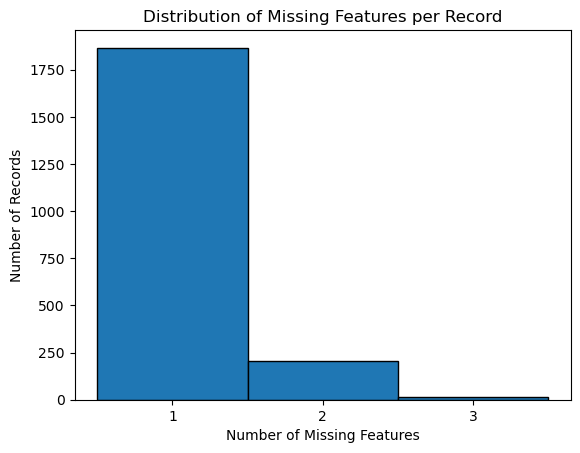

In [13]:
# calculate and show number of records missing certain number of features

total_records = len(data_train)
num_missing_features = data_train.isnull().sum(axis=1)
num_missing_features_not_zero = num_missing_features[num_missing_features > 0]
percent_records_missing_value = len(num_missing_features_not_zero) / total_records

print(f"Percentage of records missing at least one feature: {percent_records_missing_value:.2%}")
print()

plt.hist(num_missing_features_not_zero, bins=range(1, num_missing_features_not_zero.max() + 2), edgecolor='black', align='left')
plt.title("Distribution of Missing Features per Record")
plt.xlabel("Number of Missing Features")
plt.ylabel("Number of Records")
plt.xticks(range(1, num_missing_features_not_zero.max() + 1))
plt.show()

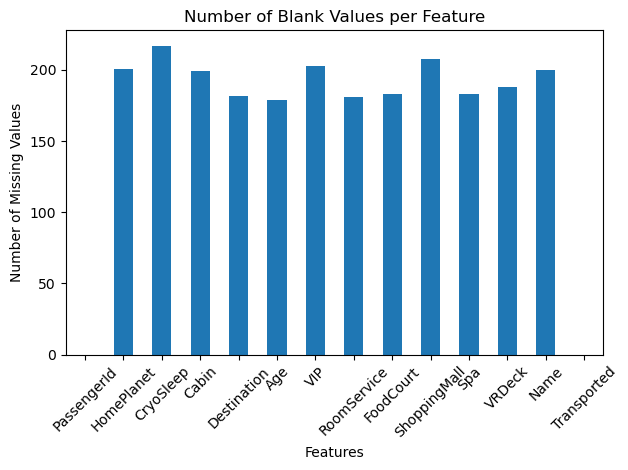

In [14]:
# show distribution of missing values per features

missing_per_feature = data_train.isnull().sum()

missing_per_feature.plot(kind="bar")
plt.title("Number of Blank Values per Feature")
plt.xlabel("Features")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Based on the charts above, it's clear that there is no real consistency between which features are missing (except that PassengerId and Transported are not missing any values, which is expected due to the nature of these items) and from this, we can draw the conclusion that the values are missing completely at random (MCAR). So we have the option of ignoring any records that are missing values and risk losing important data or we can try to impute the missing values based on other values in the dataset. Depending on the quality of this imputation, it can drastically change the accuracy of our model. I attempted both approaches to see what the results were of ignoring missing values vs imputing them.

The main problem I ran into was that if I train models on data where the missing values are ignored, I would have to do the same thing for the test data (assuming I am not using a model that can natively handle missing values) and this means I would not be able to come up with a prediction for all passengers in the test data since some of them would be removed. So after testing several models on training data that ignored the missing values, I decided to move forward with both Random Forest and Gradient Boosting models for multiple reasons. These were the two most accurate models in my training and both are also able to handle missing data natively. This meant that I could run my model on the data without removing the records with missing data or I could run the models after imputing the missing data.

## Data Cleanup

In order to clean up the data, there are a few steps I took:
1. Split the Cabin column into three different columns based on the "/" delimiter. New columns added were Deck, Num, and Side. After this, the original Cabin column was removed
2. If performing imputation, add columns for the Group number and Person number by splitting the PassengerId column and then removing it. The Group and Person numbers have important implications for imputation
3. Calculate the missing values for each column using SKLearn's IterativeImputer
4. If not imputing, remove records with blank values
5. Drop unnecessary columns (PassengerId if not imputing, Group & Person if imputing; and Name)

Overall, cleaning the data did not require that many steps but after having done the analysis and made a submission to Kaggle, I suspect a large portion of the success of the model comes from being able to impute the correct missing values (more on this later). Below is the function I used to perform the data cleanup.

In [18]:
def clean_data_and_impute(data, impute=False, predict=False):
    """
    Performs several steps to clean up the given data for analysis
    :param data: DataFrame to be cleaned up
    :param impute: boolean for if missing values should be imputed or ignored
    :return data: DataFrame after clean up steps have been taken
    """
    # split Cabin column into columns for Deck, Num, and Side
    data[["Deck", "Num", "Side"]] = data["Cabin"].str.split("/", expand=True)
    data = data.drop(["Cabin"], axis=1)

    # if impute, create imputer and split PassengerId column
    if impute:
        imputer = IterativeImputer(missing_values=-1, max_iter=100)
        data[["Group", "Person"]] = data["PassengerId"].str.split("_", expand=True)
        data = data.drop(["PassengerId"], axis=1)

    # loop through columns in dataframe
    for col in data.columns:

        # if col dtype is object or boolean, convert to numeric values
        if data[col].dtype == "object":
            data[col] = pd.factorize(data[col])[0]
        elif data[col].dtype == "bool":
            data[col] = data[col].astype(int)

        # if impute is true, replace missing values with -1, else remove those records
        # then perform iterative imputation
        if impute:
            data.fillna({col: -1}, inplace=True)
            if col != "Name":
                data[col] = imputer.fit_transform(data[[col]])
        elif predict is False:
            data = data.dropna()

    if impute:
        data = data.drop(["Group", "Person", "Name"], axis=1)
    else:
        data = data.drop(["PassengerId", "Name"], axis=1)

    return data

Now that we have a function to clean up the data, we can actually do a correlation matrix to see how much features may be correlated. This was not possible with non-numeric features so it couldn't be done until those features had been converted. To start with, this correlation matrix has not imputed any values and instead, records with blank values have been ignored.

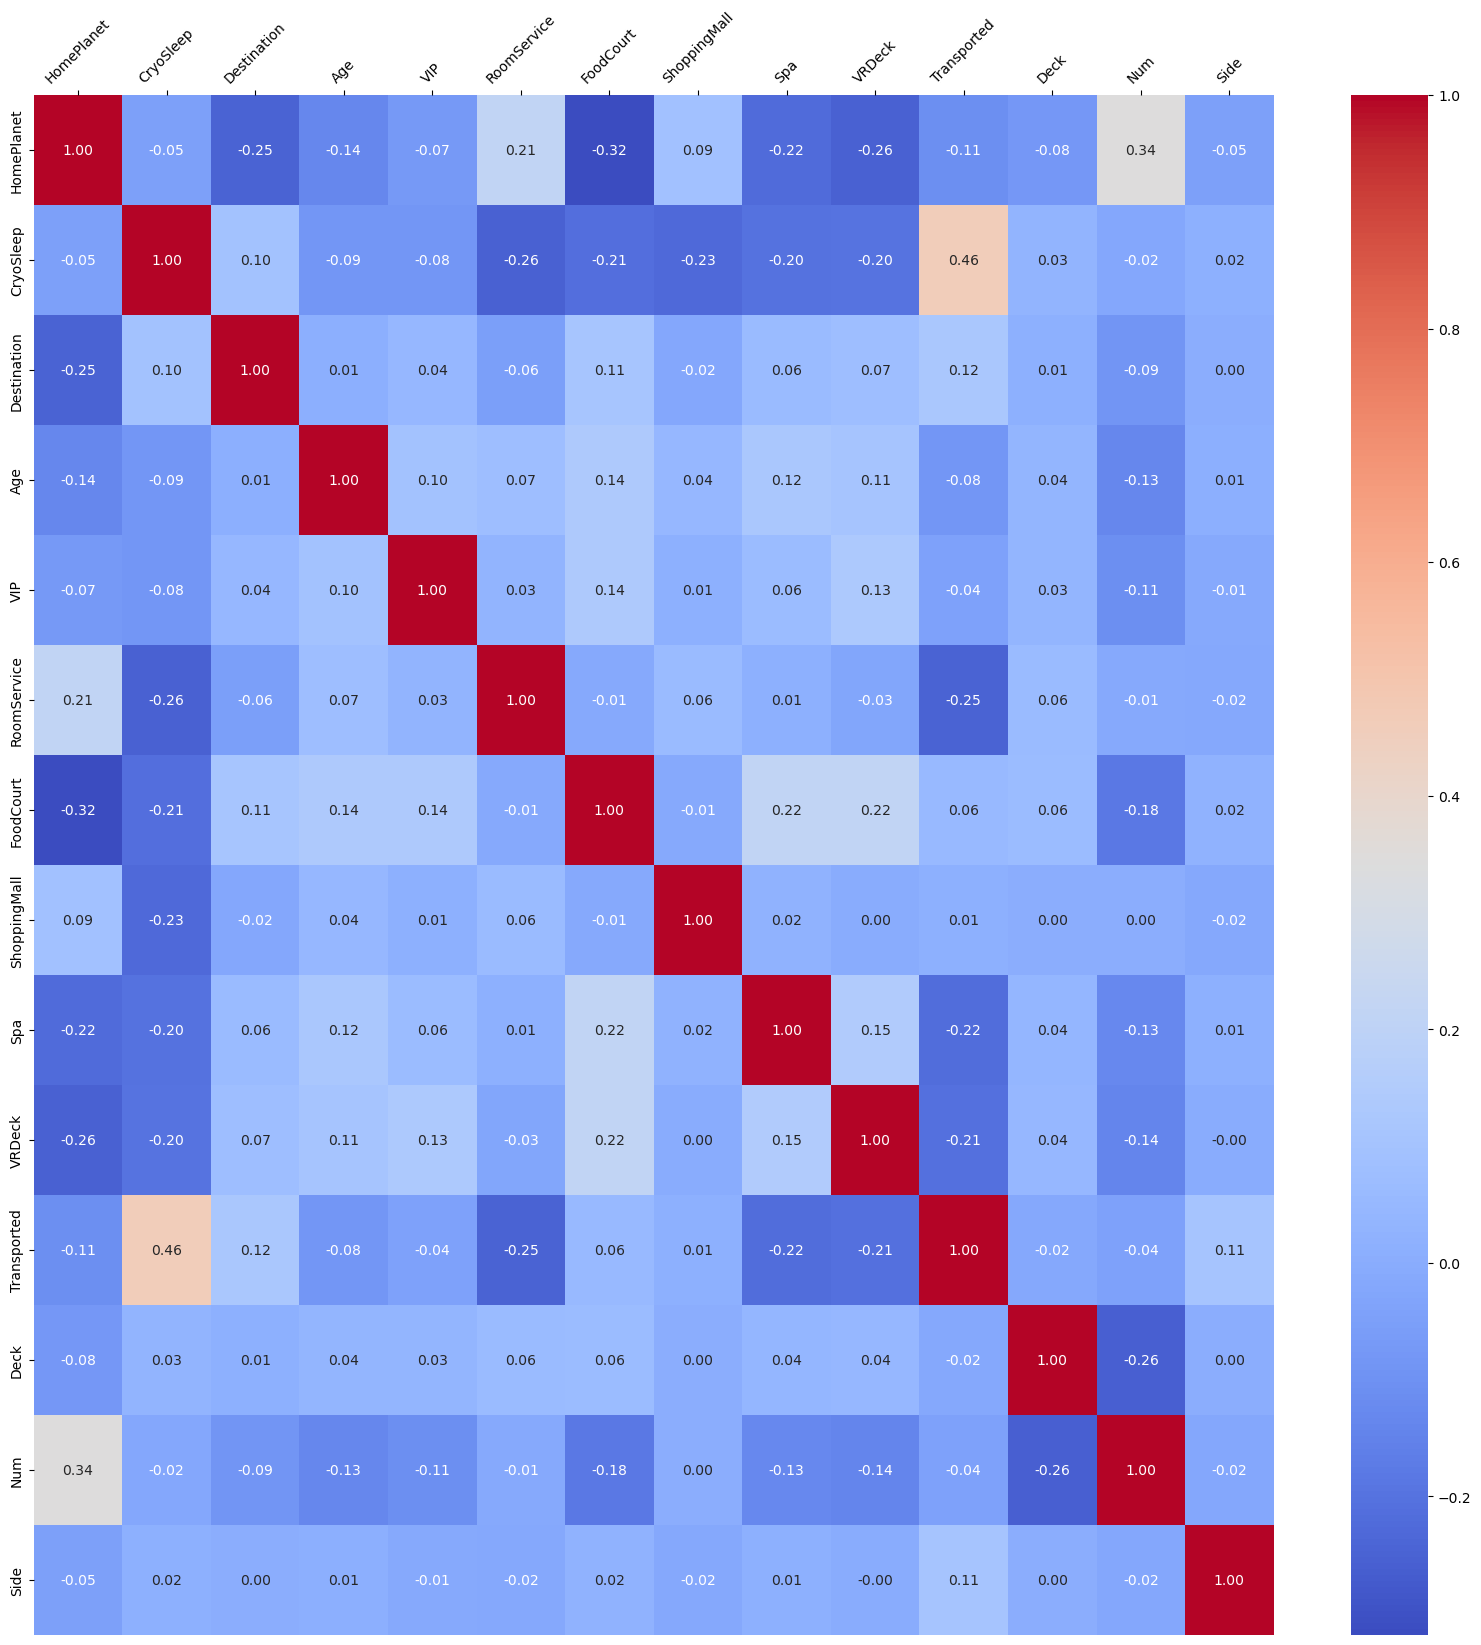

In [20]:
train_corr = clean_data_and_impute(data_train).corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax.xaxis.set_ticks_position("top")
sns.heatmap(data=train_corr, cmap="coolwarm", annot=True, fmt=".2f", ax=ax)
plt.xticks(rotation=45)
plt.show()

As we can see from the heatmap, the features in this dataset are not highly correlated. The only feature that could potentially be moderately correlated with our Transported classification is CryoSleep. However, 0.46 is not a strong correlation so it's unlikely to be a major predicting feature by itself and it's more likely that several features will need to be used to determine if a passenger was transported. The lack of correlation also suggests that none of the features are strongly collinear. From a theoretical standpoint, RoomService and FoodCourt could have an inverse relationship in that when passengers are spending money at the food court, they are less likely to be ordering room service. However, the absolute value of 0.01 suggests that these two features are completely independent from each other.

Let's now look at a correlation matrix with imputed values instead of ignoring the blank values.

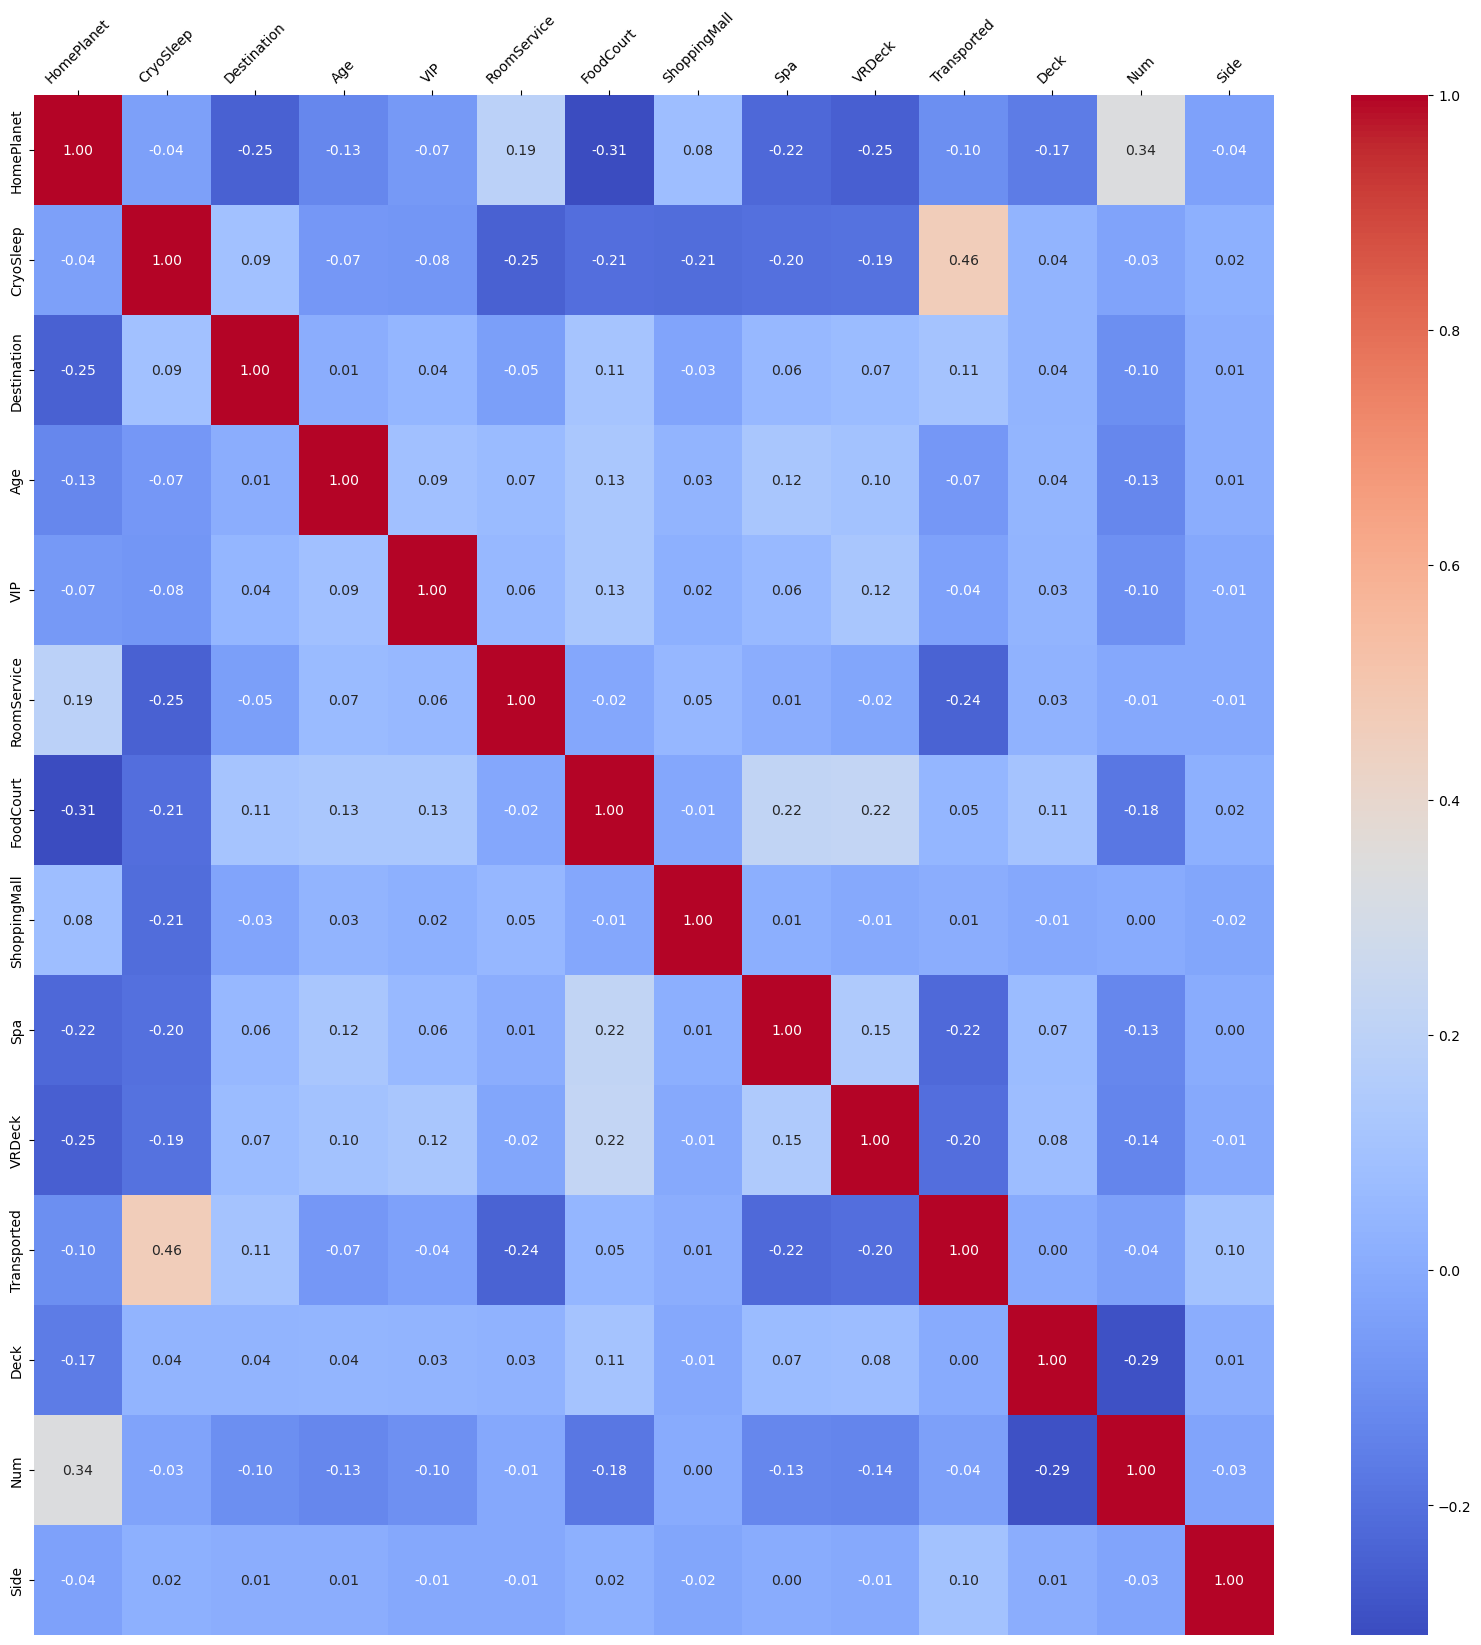

In [22]:
train_corr = clean_data_and_impute(data_train, True).corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax.xaxis.set_ticks_position("top")
sns.heatmap(data=train_corr, cmap="coolwarm", annot=True, fmt=".2f", ax=ax)
plt.xticks(rotation=45)
plt.show()

This heatmap looks almost exactly the same, suggesting that the features listed here are not strongly correlated or collinear. Another potential issue could be how we are imputing the missing values (again, more on this later).

## Model Selection

I decided that I wanted to test multiple models with both imputed values and blank values being removed before preceding with a model that I would use on the test data supplied by Kaggle to generate a CSV I could upload as my submission. This was very much a brute-force method but I structured my code in such a way that I could let it run for multiple models and I could record the results and compare later. My initial thought was that decision trees and ensembles would do well here given the lack of correlation of the features and categorical values that would drive the end result.

Below is the code I used. This whole script was taking 15-20 mins to run on my PC using PyCharm so I have not run the code in this notebook. Instead, I have included the code so it can be referenced and saved dictionaries of my results in a separate cell.

In [26]:
# helper functions for analysis
def grid_search(feature_names, estimator, param_grid, cv=5, scoring="accuracy"):
    """
    Given some parameters, tests the estimator using GridSearchCV for the best hyperparameters to supply to the model

    :param feature_names: list of features to rank
    :param estimator: model to use as for GridSearchCV
    :param param_grid: dict of parameters to test
    :param cv: cv for GridSearchCV
    :param scoring: scoring for GridSearchCV
    :return: instance of the estimator that will use the best hyperparameters from GridSearchCV
    """
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring=scoring)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_
    print(model)

    if hasattr(model, "feature_importances_"):
        feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': model.feature_importances_})
        feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
        print(feature_importance)

    return model

def model_metrics(model, X_test, y_test):
    """
    Given a model and X-test data to test, returns predictions and prints some metrics
    :param model: classification model used for predictions
    :param X_test: data to be predicted by the model
    :param y_test: data to be used to verify accuracy of predictions
    :return y_pred: predictions based on model and X-test given
    """
    y_pred = model.predict(X_test)
    print(str(model) + " prediction metrics:")
    print(confusion_matrix(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    return y_pred

In [27]:
# prepare data and split it into training and test sets
clean_data = clean_data_and_impute(data_train, impute=True)

# set X and y
y = clean_data["Transported"].values
y = np.array(pd.to_numeric(y))
X = clean_data.drop(["Transported"], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = clean_data.drop(["Transported"], axis=1).columns

In [28]:
# Model testing

# steps are the same for each model:
# 1. create model and fit to training data using default hyperparameters
# 2. calculate and print accuracy of defaul hyperparameters
# 3. create grid of important hyperparameters for the model that we want to test
# 4. test those hyperparameters using GridSearchCV
# 5. calculate and print accuracy of best model returned by GridSearchCV

# This is all commneted out because it will take a long time to run.




# """ logistical analysis """
# # using accuracy as primary metric
# log_reg = LogisticRegression(random_state=42, max_iter=10000).fit(X_train, y_train)
# y_pred = model_metrics(log_reg, X_test, y_test)

# # use grid search to see if we can't improve these metrics
# param_grid = {
#     "C": [0.01, 0.1, 1, 10, 100],
#     "penalty": ["l2", "l1", "elasticnet"],
#     "solver": ["lbfgs", "saga", "liblinear"],
#     "class_weight": [None, "balanced"]
# }

# # create new model using grid search and test predictions
# log_reg_grid = grid_search(feature_names, log_reg, param_grid)
# y_pred = model_metrics(log_reg_grid, X_test, y_test)



# """ decision tree analysis """
# # using accuracy as primary metric
# tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
# y_pred = model_metrics(tree, X_test, y_test)

# # let's use grid search to see if we can't improve these metrics
# param_grid = {
#     "max_depth": [5, 10, 15],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 3, 4, 5],
# }

# # create new model using grid search and test predictions
# tree_grid = grid_search(feature_names, tree, param_grid)
# y_pred = model_metrics(tree_grid, X_test, y_test)



# """ random forest analysis """
# forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)
# y_pred = model_metrics(forest, X_test, y_test)

# # let's use grid search to see if we can't improve these metrics
# param_grid = {
#     "max_depth": [10, 20, 30],
#     "min_samples_split": np.arange(2, 11),
#     "min_samples_leaf": np.arange(1, 5)
# }

# # create new model using grid search and test predictions
# forest_grid = grid_search(feature_names, forest, param_grid)
# y_pred = model_metrics(forest_grid, X_test, y_test)



# """ AdaBoost """
# ada_boost = AdaBoostClassifier(random_state=42).fit(X_train, y_train)
# y_pred = model_metrics(ada_boost, X_test, y_test)

# # let's use grid search to see if we can't improve these metrics
# param_grid = {
#     "n_estimators": [50, 100, 200],
#     "learning_rate": [0.01, 0.1, 1],
# }

# # create new model using grid search and test predictions
# ada_boost_grid = grid_search(feature_names, ada_boost, param_grid)
# y_pred = model_metrics(ada_boost_grid, X_test, y_test)



# """ Gradiant boost"""
# grad_boost = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
# y_pred = model_metrics(grad_boost, X_test, y_test)

# # let's use grid search to see if we can't improve these metrics
# param_grid = {
#     "n_estimators": [50, 100, 200],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "max_depth": [1, 5, 10]
# }

# # create new model using grid search and test predictions
# grad_boost_grid = grid_search(feature_names, grad_boost, param_grid)
# y_pred = model_metrics(grad_boost_grid, X_test, y_test)



# """ SVC """
# svc = SVC(random_state=42).fit(X_train, y_train)
# y_pred = model_metrics(svc, X_test, y_test)

# # let's use grid search to see if we can't improve these metrics
# param_grid = {
#     "C": [0.1, 1, 10, 100],
#     "gamma": [0.001, 0.01, 0.1, 1],
# }

# # create new model using grid search and test predictions
# svc_grid = grid_search(feature_names, svc, param_grid)
# y_pred = model_metrics(svc_grid, X_test, y_test)

As part of this, I also printed out the confusion matrix and feature_importances for each model to see if there were any patterns between them but when selecting my models that I wanted to implement for the actual test data going forward, I mainly focused on accuracy. Here are the accuracy results I recorded for both ignoring blank values and imputing those values.

In [30]:
accuracy_results_no_imp = {
    "Linear": (0.80, 0.79),
    "Decision Tree": (0.75, 0.76),
    "Random Forest": (0.80, 0.80),
    "AdaBoost": (0.79, 0.80),
    "Gradient Boost": (0.81, 0.79),
    "SVC": (0.79, 0.75)
}

accuracy_results_imp = {
    "Linear": (0.78, 0.77),
    "Decision Tree": (0.74, 0.76),
    "Random Forest": (0.78, 0.79),
    "AdaBoost": (0.78, 0.78),
    "Gradient Boost": (0.80, 0.80),
    "SVC": (0.77, 0.73)
}

for key, val in accuracy_results_no_imp.items():
    print("Accuracy for " + key + " using default hyperparameters without imputation: " + str(val[0]))
    print("Accuracy for " + key + " using GridSearchCV hyperparameters without imputation: " + str(val[1]))
    print()
    
print()

for key, val in accuracy_results_imp.items():
    print("Accuracy for " + key + " using default hyperparameters with imputation: " + str(val[0]))
    print("Accuracy for " + key + " using GridSearchCV hyperparameters with imputation: " + str(val[1]))
    print()

Accuracy for Linear using default hyperparameters without imputation: 0.8
Accuracy for Linear using GridSearchCV hyperparameters without imputation: 0.79

Accuracy for Decision Tree using default hyperparameters without imputation: 0.75
Accuracy for Decision Tree using GridSearchCV hyperparameters without imputation: 0.76

Accuracy for Random Forest using default hyperparameters without imputation: 0.8
Accuracy for Random Forest using GridSearchCV hyperparameters without imputation: 0.8

Accuracy for AdaBoost using default hyperparameters without imputation: 0.79
Accuracy for AdaBoost using GridSearchCV hyperparameters without imputation: 0.8

Accuracy for Gradient Boost using default hyperparameters without imputation: 0.81
Accuracy for Gradient Boost using GridSearchCV hyperparameters without imputation: 0.79

Accuracy for SVC using default hyperparameters without imputation: 0.79
Accuracy for SVC using GridSearchCV hyperparameters without imputation: 0.75


Accuracy for Linear using

As we can see, there is little variation between the default parameters and GridSearchCV parameters for most models. There is also little variation between ignoring blank values or imputing them. This led me to selecting Random Forest and Gradient Boosting as the two models I wanted to proceed with because both can handle blank values natively and had relatively high accuracy when compared to the other models.

## Results and Anlaysis

I have included my code below for how I was using my selected models to predict the test data supplied by Kaggle. After splitting the training data and using part of it to train and part to test, I trained both models on the full training data without splitting and then used those models to predict results based on the testing data provided by Kaggle. Then I just had to upload my CSV(s) to Kaggle and see how I did compared to others.

In [34]:
# helper functions for predictions
def test_training_data(data, model, impute=False, predict=False):

    data = clean_data_and_impute(data, impute, predict)

    y = data["Transported"].values
    y = np.array(pd.to_numeric(y))
    X = data.drop(["Transported"], axis=1).values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)

def predict_actual_data(data_train, data_test, model, model_type, impute=False):

    pass_id = data_test["PassengerId"]

    data_train = clean_data_and_impute(data_train, impute, True)
    data_test = clean_data_and_impute(data_test, impute, True)

    y_train = data_train["Transported"].values
    y_train = np.array(pd.to_numeric(y_train))
    X_train = data_train.drop(["Transported"], axis=1).values

    model = model.fit(X_train, y_train)
    y_pred = model.predict(data_test.values).astype(bool)

    output_df = pd.DataFrame({
        "PassengerId": pass_id,
        "Transported": y_pred
    })

    # commented out code that saves CSV
    # output_df.to_csv("spaceship-titanic/My submissions/" + model_type + "_" + "impute-" + str(impute) + "_submission.csv", index=False)

    return None

In [35]:
# train models one last time and then make predictions
data_train = pd.read_csv("spaceship-titanic/train.csv")
data_test = pd.read_csv("spaceship-titanic/test.csv")

# hist gradient boosting natively supports no imputation so it is used for that model
# standard gradient boosting used with imputation and random forest used for both
forest = RandomForestClassifier()
hist_grad_boost = HistGradientBoostingClassifier()
grad_boost = GradientBoostingClassifier()

# without imputing
forest_acc_no_imp = round(test_training_data(data_train, forest, predict=True), 2)
grad_acc_no_imp = round(test_training_data(data_train, forest, predict=True), 2)

print("forest accuracy, no imputing: " + str(forest_acc_no_imp))
print("gradient boosting accuracy, no imputing: " + str(grad_acc_no_imp))

predict_actual_data(data_train, data_test, forest, "random forest")
predict_actual_data(data_train, data_test, hist_grad_boost, "gradient boosting")

# with imputing
forest_acc_imp = round(test_training_data(data_train, forest, True, True), 2)
grad_acc_imp = round(test_training_data(data_train, grad_boost, True, True), 2)

print("forest accuracy, with imputing: " + str(forest_acc_imp))
print("gradient boosting accuracy, with imputing: " + str(grad_acc_imp))

predict_actual_data(data_train, data_test, forest, "random forest", True)
predict_actual_data(data_train, data_test, grad_boost, "gradient boosting", True)

forest accuracy, no imputing: 0.8
gradient boosting accuracy, no imputing: 0.79
forest accuracy, with imputing: 0.78
gradient boosting accuracy, with imputing: 0.8


And below, I've added the actual accuracies from my submissions to Kaggle and plotted them.

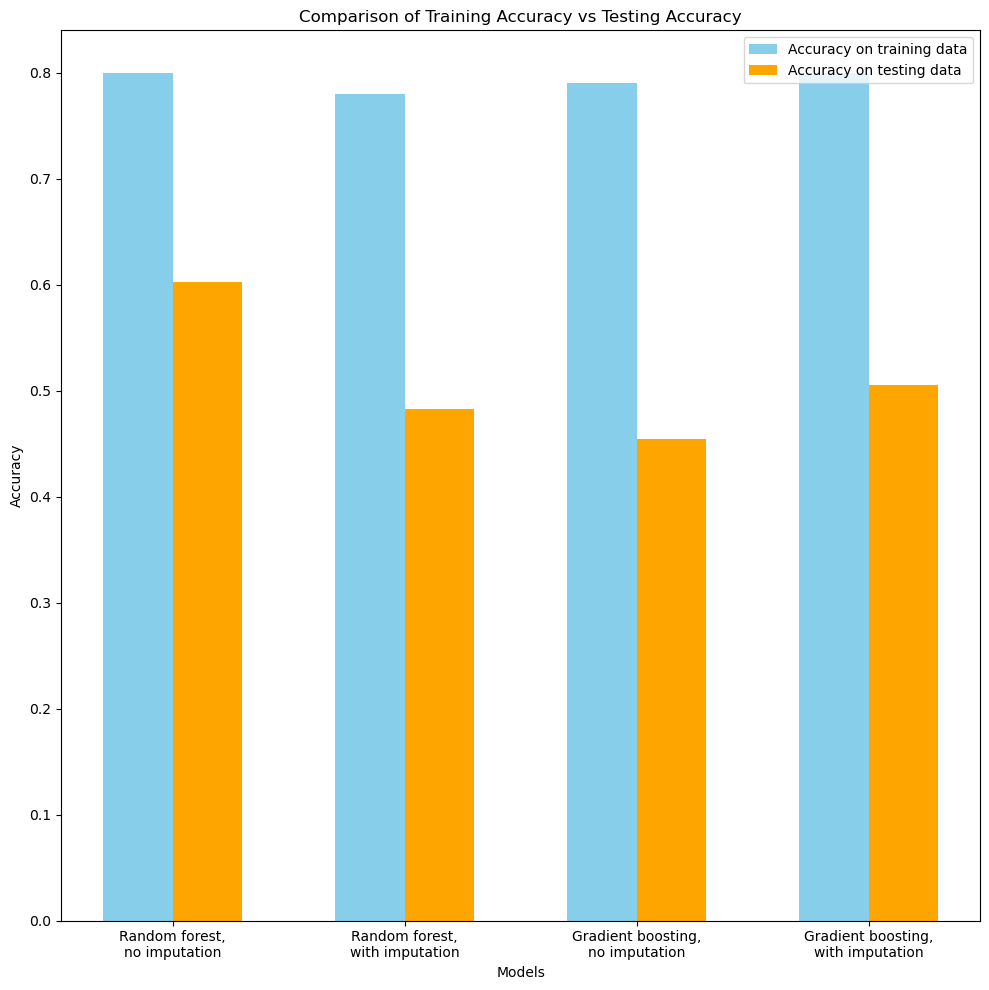

In [37]:
random_forest_no_imp = 0.60252
random_forest_imp = 0.48258
grad_boost_no_imp = 0.45405
grad_boost_imp = 0.50526

models = ["Random forest,\nno imputation", "Random forest,\nwith imputation", "Gradient boosting,\nno imputation", "Gradient boosting,\nwith imputation"]
training_acc = [forest_acc_no_imp, forest_acc_imp, grad_acc_no_imp, grad_acc_imp]
testing_acc = [random_forest_no_imp, random_forest_imp, grad_boost_no_imp, grad_boost_imp]

# Bar width
bar_width = 0.3
index = range(len(models))

# Create the bar chart
plt.figure(figsize=(10, 10))
plt.bar(index, training_acc, bar_width, label='Accuracy on training data', color='skyblue')
plt.bar([i + bar_width for i in index], testing_acc, bar_width, label='Accuracy on testing data', color='orange')

# Add labels and legend
plt.title("Comparison of Training Accuracy vs Testing Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend()
plt.tight_layout()
plt.show()

As we can see from the numbers and the plot, my models significantly underperformed on actual testing data when compared to the training data. I think it's pretty safe to say that it's an issue with how I've processed the missing values.

When training my models, I handled the missing values first and then split the data into training data and testing data. This means that any incorrect imputations affected both the training data and testing data, skewing my training accuracy scores in a positive way. Since the imputations were done in the same way on the training and testing data, they could be incorrect in both datasets. Therefore, my model is using incorrect data to train itself and then using the incorrect training by making predictions and comparing those predictions to yet more incorrect data, something that does not happen when predicting the actual testing data. This is a classic example of confirmation bias. When dealing with actual testing data, my incorrect imputations reveal themselves and my accuracy score plummets.

I did consider that perhaps my models were overfitted, however, I believe this overfitting would be more apparent through my GridSearchCV analysis. Since the accuracy of the cross validation was not that different from the accuracy while using default settings for the models, I believe the more imporant thing to consider is how to process missing values differently.

## Final Thoughts

I think there are a few things I could work on to improve my models for this exercise. One is to look back at the confusion matrices during my testing and see if I notice any patterns of false positives or false negatives with certain models. I also did look through feature importances while I was training my models and didn't notice an real consistencies other than CryoSleep was usually considered most important by my models. We can also see this in the correlation matrix but I maintain that there is not a single feature here that can be used to accurately predict the transported passengers. I believe it is a combination of features and the ability of a model to make accurate predictions is most heavily influenced by how well it is able to impute missing values. Correctly imputing these values on the training data will not only aid in correctly imputing the values in the testing data, it will also lead to better trained models that can make more accurate predictions.

As I compare my most accurate Kaggle submissions with the top numbers on the leaderboard, I would say my results are pretty abyssmal. As of this writing, my best result is ranked around 2000 out of about 2100 non-zero scores. My takeaway from this is that I have a lot to learn :) But more specifically, I think this was an example where imputing the missing values is both extremely important and extremely complex. It is not as simple as being able to calculate the mean based on other values or replacing missing values with a constant. Imputing missing values for this data requires detailed analysis of patterns. For example, if a passenger is missing their HomePlanet but they share a group number with other passengers from Europa, they are from Europa. As another example, if a passenger is a VIP from Mars on their way to TRAPPIST-1e, they are definitely staying on Deck D, E, or F, and they elected not to be in CryoSleep. 85% of these VIPs were not transported to another dimension.

These are the types of patterns that I noticed when looking at the data myself so I know there is a systematic way that this data was prepared and that means there also exists a systematic way that these patterns can be analyzed and missing values can be imputed. Much of this is beyond the scope of this class and difficult to do manually. I am also unfamiliar with Python libraries that can be used to impute these values and clearly IterativeImputer from SKLearn did not do a fantastic job. Perhaps there are also more advanced models that can be used for this purpose. My plan is to come back to this challenge (maybe as part of the next final project if it makes sense) and see if I can apply new techniques we've learned to make more accurate predictions.